We'd like to study how TCR-BERT performs when applying various analyses to datasets not seen during its training. Here, we examine this problem using the set of human TRBs presented in Glanville et al. 

In [1]:
import os, sys
import logging
import json
import tempfile
import itertools
import collections
import importlib

import tqdm

import numpy as np
import pandas as pd
from sklearn import metrics
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper

from transformers import BertModel, BertForMaskedLM, BertTokenizer, FeatureExtractionPipeline

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import custom_metrics
import data_loader as dl
import featurization as ft
import canonical_models as models
import model_utils
import plot_utils
import utils
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)
import transformer_custom as trans
import conv

DEVICE = utils.get_device(3)
TRAINED_MODEL_DIR = "/home/wukevin/projects/tcr/tcr_models"

FILT_EDIT_DIST = True

# Classifier tuned from MLM on PIRD antigen + TRB data
TRANSFORMER = 'wukevin/tcr-bert'

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/glanville_transformer_classifier")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'/home/wukevin/projects/tcr/tcr-bert/plots/glanville_transformer_classifier'

In [2]:
importlib.reload(dl)
glanville = dl.load_glanville()
glanville.head()

,Source_Type,Source,HLA,Antigen-species,CDR3b,Antigen,Antigen-peptide,CDR3b_spaced
0,PDB,1oga,HLA-A2,flu,CASSSRSSYEQYF,M1,GILGFVFTL,C A S S S R S S Y E Q Y F
1,PDB,3gsn,HLA-A2,CMV,CASSPVTGGIYGYTF,pp65,NLVPMVATV,C A S S P V T G G I Y G Y T F
2,PDB,3o4l,HLA-A2,EBV,CSARDGTGNGYTF,BMLF1,GLCTLVAML,C S A R D G T G N G Y T F
3,SingleCell,subject.0275,HLA-A2,CMV,CASRPDGRETQYF,pp65,NLVPMVATV,C A S R P D G R E T Q Y F
4,SingleCell,subject.0275,HLA-A2,CMV,CASSETGFGNQPQHF,pp65,NLVPMVATV,C A S S E T G F G N Q P Q H F


In [3]:
collections.Counter(glanville['HLA'])

Counter({'HLA-A2': 1492, 'HLA-A1': 296, 'HLA-B7': 279})

In [4]:
collections.Counter(glanville['Antigen'])

Counter({'M1': 587,
         'pp65': 231,
         'BMLF1': 739,
         'pp50': 271,
         'NP44': 25,
         'NP177': 214})

## Embedding visualization

We start by visualizing the embedding that TCR-BERT produces for each of these sequences.

In [5]:
embedding_kwargs = {"method": "mean", "layers": [-1]}
glanville_embeddings = model_utils.get_transformer_embeddings(
    TRANSFORMER, list(glanville['CDR3b']), **embedding_kwargs,
    device=3,
)
glanville_embeddings.shape

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(2067, 768)

In [6]:
glanville_embedding_adata = ad.AnnData(
    glanville_embeddings,
    obs=glanville,
)
sc.pp.pca(glanville_embedding_adata, n_comps=50)
sc.pp.neighbors(glanville_embedding_adata)
sc.tl.umap(glanville_embedding_adata)
glanville_embedding_adata

/home/wukevin/miniconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2067 × 768
    obs: 'Source_Type', 'Source', 'HLA', 'Antigen-species', 'CDR3b', 'Antigen', 'Antigen-peptide', 'CDR3b_spaced'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

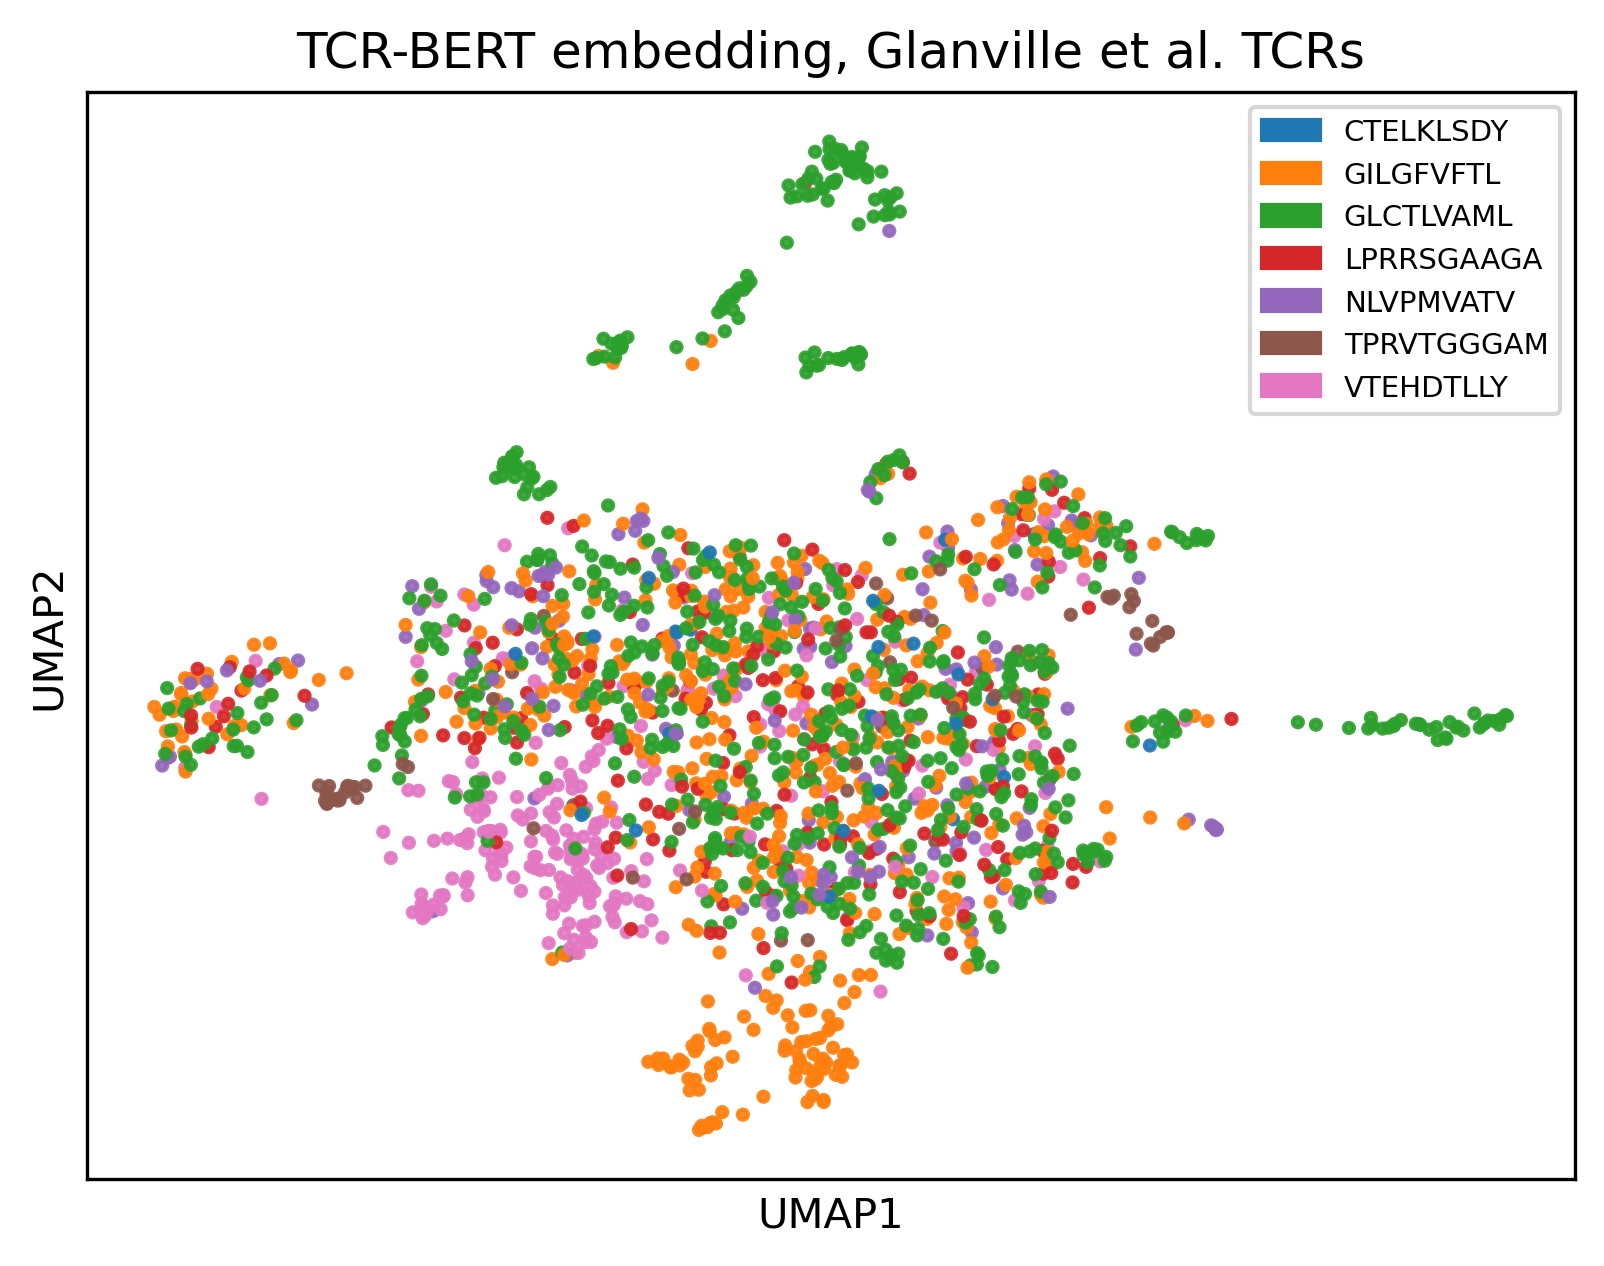

In [7]:
importlib.reload(plot_utils)
plot_utils.plot_anndata_rep(
    glanville_embedding_adata, color='Antigen-peptide', direct_label=False, cmap=plt.get_cmap('tab10'),
    title="TCR-BERT embedding, Glanville et al. TCRs",
    legend_size=7,
    fname=os.path.join(PLOT_DIR, "glanville_embed_umap_antigen.pdf"),
).show()

We observe that TCR-BERT's embedding separates out several groups of antigen specific clusters. Unlike single-cell RNA seq clusters which tend to be fairly large, these tend to be fairly small and localized. This separation allows us to do interesting analyses like isolating one particular cluster and finding a corresponding motif, as shown below.

In [8]:
sc.tl.leiden(glanville_embedding_adata, resolution=2.0)

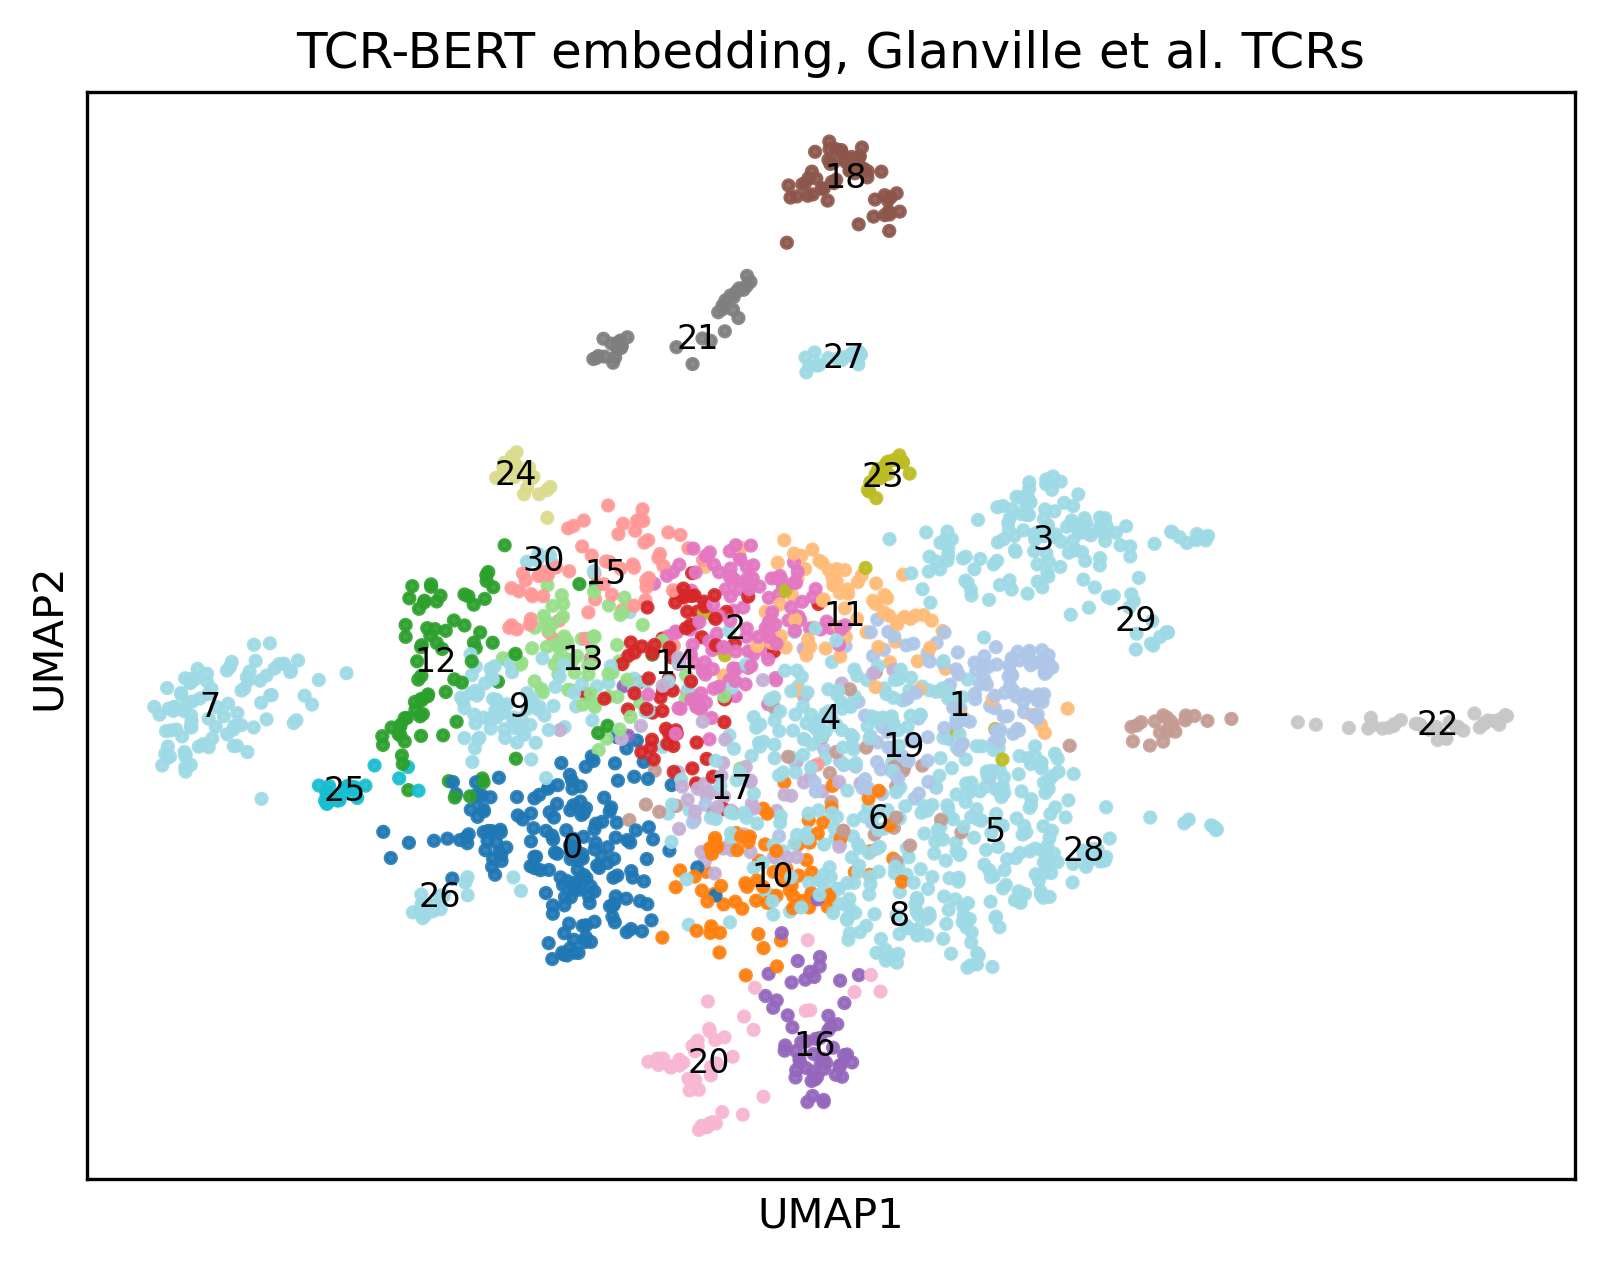

In [9]:
importlib.reload(plot_utils)
plot_utils.plot_anndata_rep(
    glanville_embedding_adata, color='leiden', direct_label=True,
    title="TCR-BERT embedding, Glanville et al. TCRs",
    legend_size=8,
).show()

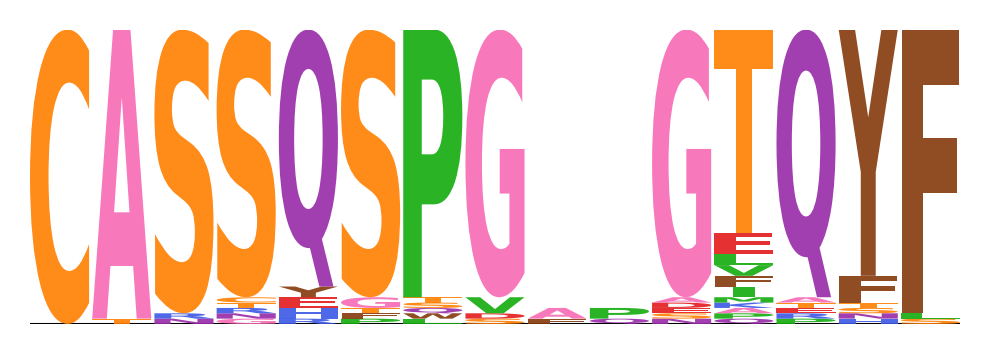

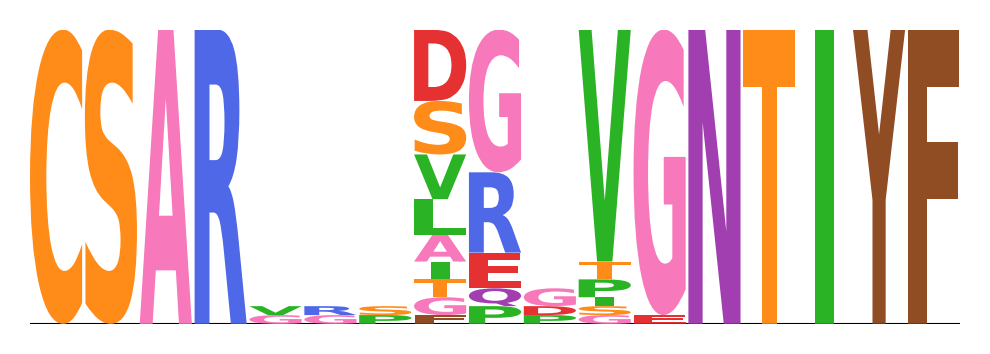

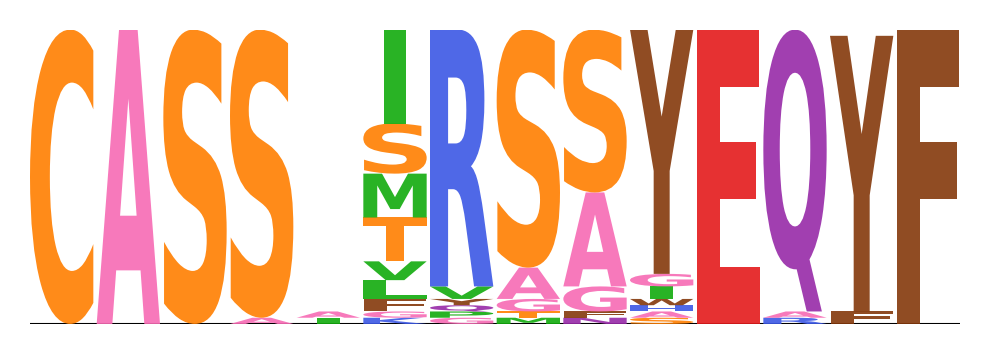

In [11]:
def motif_from_cluster(cluster:str, fname=None):
    cluster_of_interest = glanville_embedding_adata.obs.iloc[
        np.where(glanville_embedding_adata.obs['leiden'] == cluster)
    ]
    assert len(cluster_of_interest) > 0

    logo_kwargs = {
        "color_scheme": "dmslogo_funcgroup",
        "show_spines": False,
        "alpha": 0.9,
    }
    fig, ax = plt.subplots(figsize=(4, 1.3), dpi=300)
    custom_metrics.motif_from_sequences(cluster_of_interest['CDR3b'], normalize_pwm=False, ax=ax, **logo_kwargs)[1]
    ax.set(
        xticks=[],
        yticks=[],
    )
    if fname is not None:
        fig.savefig(fname, bbox_inches='tight')
    return fig

figs = [motif_from_cluster(c, fname=os.path.join(PLOT_DIR, f"glanville_embed_cluster_motif_{c}.pdf")) for c in ['18', '22', '20']]
for f in figs:
    f.show()

## Model training

We have seen that TCR-BERT produces a reasonable embedding for these sequences. Next, we ask whether TCR-BERT can also enable us to build a strong classifier of antigen binding (binary) given a TRB sequence. To do this, we apply a PCA-SVM on top of TCR-BERT's embeddings.

We do not do this for all antigens presented in the Glanville dataset, as some of these antigens were seen during TCR-BERT's classification pre-training stage. Instead, we focus on a set of TRB's known to bind to the NP177 antigen, which was not seen during training, verified using:

```bash
cat pird_tcr_ab.csv | grep LPRRSGAAGA
```

The above returns empty output, which indicates that the given antigen is not in the PIRD database.

In [12]:
unseen_antigen = "LPRRSGAAGA"
glanville_sub = glanville.loc[glanville['Antigen-peptide'] == unseen_antigen]
glanville_sub

,Source_Type,Source,HLA,Antigen-species,CDR3b,Antigen,Antigen-peptide,CDR3b_spaced
500,bulk-Davis,subject-0959,HLA-B7,flu,CASSLGAAVREQYF,NP177,LPRRSGAAGA,C A S S L G A A V R E Q Y F
501,bulk-Davis,subject-0959,HLA-B7,flu,CASSPGTDTQYF,NP177,LPRRSGAAGA,C A S S P G T D T Q Y F
502,bulk-Davis,subject-0959,HLA-B7,flu,CASSVESGGLSYEQYF,NP177,LPRRSGAAGA,C A S S V E S G G L S Y E Q Y F
527,bulk-Davis,subject-1633,HLA-B7,flu,CAGGTDYEQYF,NP177,LPRRSGAAGA,C A G G T D Y E Q Y F
528,bulk-Davis,subject-1633,HLA-B7,flu,CAMREGRRDDKIIF,NP177,LPRRSGAAGA,C A M R E G R R D D K I I F
...,...,...,...,...,...,...,...,...
1800,bulk-Davis,subject-2351,HLA-B7,flu,CASSSGTSVNDEQFF,NP177,LPRRSGAAGA,C A S S S G T S V N D E Q F F
1801,bulk-Davis,subject-2351,HLA-B7,flu,CAWSDRGLVDTQYF,NP177,LPRRSGAAGA,C A W S D R G L V D T Q Y F
1802,bulk-Davis,subject-2351,HLA-B7,flu,CAWSGDGGTEAFF,NP177,LPRRSGAAGA,C A W S G D G G T E A F F
1804,bulk-Davis,subject-2385,HLA-B7,flu,CASSGDHSYEQYF,NP177,LPRRSGAAGA,C A S S G D H S Y E Q Y F


In [13]:
collections.Counter(glanville_sub['Antigen'])

Counter({'NP177': 214})

In [14]:
collections.Counter(glanville_sub['HLA'])

Counter({'HLA-B7': 214})

In [15]:
collections.Counter(glanville_sub['Source'])

Counter({'subject-0959': 3,
         'subject-1633': 176,
         'subject-2350': 28,
         'subject-2351': 5,
         'subject-2385': 2})

Given the distribution of patients, we use subject-1633 as a training set, and the other patients as a held out test set.

In [16]:
train_patient = "subject-1633"
test_patients = [pat for pat in utils.dedup(glanville_sub['Source'])]
train_pos_trbs = glanville_sub.loc[glanville_sub['Source'] == train_patient]['CDR3b']
test_pos_trbs = glanville_sub.loc[glanville_sub['Source'] != train_patient]['CDR3b']
len(train_pos_trbs), len(test_pos_trbs)

(176, 38)

Since this dataset only gives us positive, binding TRBs, introduce a negative background of randomly sampled human TRBs from TCRdb. 

In [17]:
importlib.reload(dl)
neg_trbs = dl.sample_unlabelled_tcrdb_trb(len(glanville_sub) * 5, seed=6489)
train_neg_trbs = neg_trbs[:len(train_pos_trbs) * 5]
test_neg_trbs = neg_trbs[len(train_pos_trbs) * 5:]
len(train_neg_trbs), len(test_neg_trbs)

INFO:root:Dropping 4 TCRdb entries for unknown TRA TRB status
INFO:root:TCRdb: Removing 0 entries with non-amino acid residues


(880, 190)

In [18]:
train_trbs = list(train_pos_trbs) + train_neg_trbs
train_labels = [1] * len(train_pos_trbs) + [0] * len(train_neg_trbs)
assert len(train_trbs) == len(train_labels), f"{len(train_trbs)} {len(train_labels)}"
test_trbs = list(test_pos_trbs) + test_neg_trbs
test_labels = [1] * len(test_pos_trbs) + [0] * len(test_neg_trbs)
assert len(test_trbs) == len(test_labels)

len(train_trbs), len(test_trbs)

(1056, 228)

In [19]:
# Write example files (these are include with the repo for demonstration purposes)
ex_dir = os.path.join(
    os.path.dirname(SRC_DIR), "example_files"
)
assert os.path.isdir(ex_dir)

with open(os.path.join(ex_dir, "glanville_np177_training_patient.tsv"), 'w') as sink:
    sink.write("# glanville NP177 training patient. 1 = positive, 0 = negative.\n")
    for s, l in zip(train_trbs, train_labels):
        sink.write(f"{s}\t{l}\n")
with open(os.path.join(ex_dir, "glanville_np177_testing_patients.tsv"), 'w') as sink:
    sink.write("# glanville NP177 testing patients. 1 = positive, 0 = negative.\n")
    for s, l in zip(test_trbs, test_labels):
        sink.write(f"{s}\t{l}\n")

In [20]:
if FILT_EDIT_DIST:
    print("Sanitizing train sequences")
    train_trbs, train_labels = dl.sanitize_train_sequences(train_trbs, train_labels, test_trbs)
len(train_trbs)

1056

We embed the sequences and train PCA-SVM

In [21]:
importlib.reload(model_utils)
train_embed = model_utils.get_transformer_embeddings(
    TRANSFORMER, train_trbs, **embedding_kwargs,
    device=3,
)
test_embed = model_utils.get_transformer_embeddings(
    TRANSFORMER, test_trbs, **embedding_kwargs,
    device=3,
)
all_embed = np.vstack([train_embed, test_embed])
train_embed.shape, test_embed.shape, all_embed.shape

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS

((1056, 768), (228, 768), (1284, 768))

In [22]:
from sklearn.svm import SVC

# pcasvm = models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9)
# pcasvm.fit(train_embed, train_labels)
# test_preds = pcasvm.predict_proba(test_embed)[:, 1]

svm = SVC(probability=True, kernel='rbf', random_state=1234)
svm.fit(train_embed, train_labels)
test_preds = svm.predict_proba(test_embed)[:, 1]
metrics.average_precision_score(test_labels, test_preds)

0.4000358512334758

To contextualize this performance, we also train several other models for comparison

## ESM baseline

In [23]:
esm_train_embed = model_utils.get_esm_embedding(train_trbs, device=3)
esm_test_embed = model_utils.get_esm_embedding(test_trbs, device=3)

# esm_pcasvm = models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9)
# esm_pcasvm.fit(esm_train_embed, train_labels)
# esm_test_preds = esm_pcasvm.predict_proba(esm_test_embed)[:, 1]

esm_svm = SVC(probability=True, kernel='rbf')
esm_svm.fit(esm_train_embed, train_labels)
esm_test_preds = esm_svm.predict_proba(esm_test_embed)[:, 1]
metrics.average_precision_score(test_labels, esm_test_preds)

Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master
Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master


0.30663205593850523

## TAPE baseline

In [24]:
tape_train_embed = model_utils.get_tape_embedding(train_trbs, device=2)
tape_test_embed = model_utils.get_tape_embedding(test_trbs, device=2)

# tape_pcasvm = models.ModelOnPCA(SVC, probability=True, kernel='rbf', n_components=0.9)
# tape_pcasvm.fit(tape_train_embed, train_labels)
# tape_test_preds = tape_pcasvm.predict_proba(tape_test_embed)[:, 1]

tape_svm = SVC(probability=True, kernel='rbf')
tape_svm.fit(tape_train_embed, train_labels)
tape_test_preds = tape_svm.predict_proba(tape_test_embed)[:, 1]

metrics.average_precision_score(test_labels, tape_test_preds)

INFO:root:TAPE command: CUDA_VISIBLE_DEVICES=2 tape-embed unirep /tmp/tmphtq6oryk/input.fasta /tmp/tmphtq6oryk/output.npz babbler-1900 --tokenizer unirep --seed 1234
INFO:root:TAPE command: CUDA_VISIBLE_DEVICES=2 tape-embed unirep /tmp/tmpe5js08x9/input.fasta /tmp/tmpe5js08x9/output.npz babbler-1900 --tokenizer unirep --seed 1234


0.32197068864857314

## SETE baseline

In [25]:
train_kmers = np.stack([ft.kmer_ft(aa) for aa in train_trbs])
test_kmers = np.stack([ft.kmer_ft(aa) for aa in test_trbs])
train_kmers.shape, test_kmers.shape

((1056, 9261), (228, 9261))

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

sete_model = models.ModelOnPCA(
    GradientBoostingClassifier, n_components=0.9  # SETE
)
sete_model.fit(train_kmers, train_labels)

sete_model_train_preds = sete_model.predict_proba(train_kmers)[:, 1]
print(metrics.average_precision_score(train_labels, sete_model_train_preds))

sete_model_test_preds = sete_model.predict_proba(test_kmers)[:, 1]
metrics.average_precision_score(test_labels, sete_model_test_preds)

0.999843043696635


0.2943339927044918

## ConvNet baseline

In [27]:
importlib.reload(dl)

max_trb_len = max([len(seq) for seq in train_trbs + test_trbs])

train_convnet_dset = dl.TCRSupervisedIdxDataset(
    train_trbs, train_labels, max_len=max_trb_len,
)
test_convnet_dset = dl.TCRSupervisedIdxDataset(
    test_trbs, test_labels, max_len=max_trb_len,
)

INFO:root:Given max_len of 21 exceeds (as expected) empirical max_len of 21
INFO:root:Using maximum length of 21
INFO:root:Given max_len of 21 exceeds (as expected) empirical max_len of 20
INFO:root:Using maximum length of 21


In [28]:
torch.manual_seed(1234)

with tempfile.TemporaryDirectory() as tmpdir:
    logging.info(f"Running in temporary dir: {tmpdir}")
    net = skorch.NeuralNet(
        module=conv.OnePartConvNet,
        module__use_embedding=True,
        module__n_output=2,
        module__max_input_len=max_trb_len,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        max_epochs=250,
        batch_size=512,
        lr=1e-3,
        callbacks=[
            skorch.callbacks.LRScheduler(
                policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                mode='min',
                factor=0.1,
                patience=10,
                min_lr=1e-6,
            ),
            skorch.callbacks.GradientNormClipping(gradient_clip_value=5),
            skorch.callbacks.EpochScoring(
                "average_precision",
                lower_is_better=False,
                on_train=False,
                name="valid_auprc",
            ),
            skorch.callbacks.EarlyStopping(
                patience=25,
                monitor="valid_auprc",
                lower_is_better=False,
            ),
            skorch.callbacks.Checkpoint(  # Seems to cause errors if placed before scoring
                dirname=tmpdir,
                fn_prefix="net_",
                monitor="valid_auprc_best",
            ),
        ],
        device=3,
    )
    net.classes_ = np.unique(test_convnet_dset.all_labels())
    net.fit(train_convnet_dset)
    # Restore best weights and evaluate on test set
    cp = skorch.callbacks.Checkpoint(dirname=tmpdir, fn_prefix="net_")
    net.load_params(checkpoint=cp)

    convnet_train_truth = train_convnet_dset.all_labels()
    convnet_train_preds = net.predict_proba(train_convnet_dset)[:, 1]
    convnet_train_auprc = metrics.average_precision_score(convnet_train_truth, convnet_train_preds)
    
    convnet_test_truth = test_convnet_dset.all_labels()
    convnet_test_preds = net.predict_proba(test_convnet_dset)[:, 1]
    convnet_test_auprc = metrics.average_precision_score(convnet_test_truth, convnet_test_preds)
    del net

convnet_train_auprc, convnet_test_auprc

INFO:root:Running in temporary dir: /tmp/tmp__r2am2d


  epoch    train_loss    valid_auprc    valid_loss    cp     dur
-------  ------------  -------------  ------------  ----  ------
      1        0.7635         0.8494        0.7390     +  0.0482
      2        0.2750         0.8579        0.8145     +  0.0349
      3        0.1250         0.8521        0.9210        0.0241
      4        0.0700         0.8487        1.0635        0.0239
      5        0.0453         0.8444        1.2555        0.0235
      6        0.0318         0.8409        1.5021        0.0236
      7        0.0234         0.8392        1.8004        0.0235
      8        0.0179         0.8371        2.1429        0.0240
      9        0.0141         0.8374        2.5184        0.0239
     10        0.0112         0.8383        2.9106        0.0238
     11        0.0091         0.8394        3.3027        0.0246
     12        0.0075         0.8401        3.6793        0.0240
     13        0.0063         0.8408        4.0313        0.0241
     14        0.0054    

(0.17449783985532702, 0.14617991151750082)

## Combined plots

We now take all these models plus TCR-BERT and plot their performance

INFO:root:AUPRC of 0.4000
INFO:root:AUPRC of 0.3066
INFO:root:AUPRC of 0.3220
INFO:root:AUPRC of 0.2943
INFO:root:AUPRC of 0.1462
INFO:root:AUPRC of 0.1824


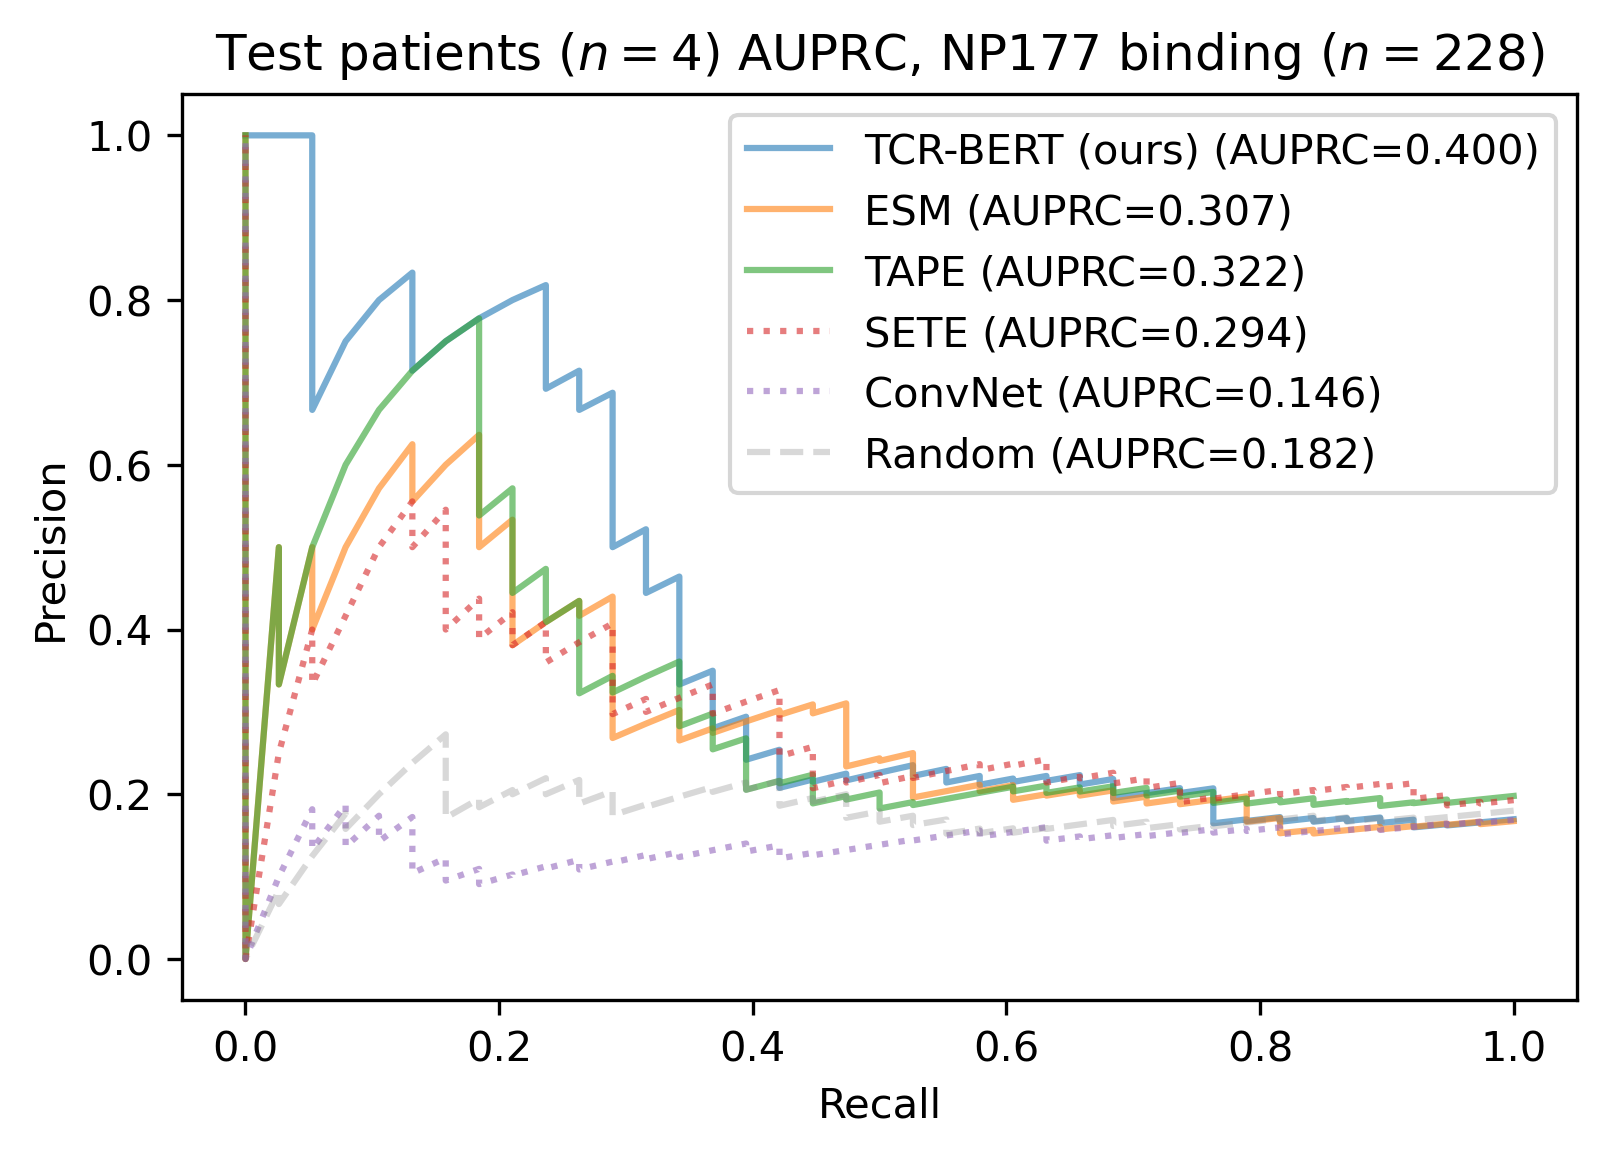

In [29]:
importlib.reload(plot_utils)

null_model_rng = np.random.default_rng(seed=1928)

fig, ax = plt.subplots(dpi=300)
plot_utils.plot_auprc(
    test_labels,
    test_preds,
    label_prefix="TCR-BERT (ours)",
    alpha=0.6,
    ax=ax,
)
plot_utils.plot_auprc(
    test_labels,
    esm_test_preds,
    label_prefix="ESM",
    alpha=0.6,
    ax=ax,
)
plot_utils.plot_auprc(
    test_labels,
    tape_test_preds,
    label_prefix='TAPE',
    alpha=0.6,
    ax=ax,
)
plot_utils.plot_auprc(
    test_labels,
    sete_model_test_preds,
    label_prefix='SETE',
    alpha=0.6, linestyle='dotted',
    ax=ax,
)
plot_utils.plot_auprc(
    test_labels,
    convnet_test_preds,
    label_prefix="ConvNet",
    ax=ax, alpha=0.6, linestyle='dotted',
)
plot_utils.plot_auprc(
    test_labels,
    null_model_rng.uniform(size=len(test_labels)),
    label_prefix="Random",
    alpha=0.3, linestyle='--', color='grey',
    ax=ax,
)
ax.legend()
ax.set(title=f"Test patients ($n=4$) AUPRC, NP177 binding ($n={len(test_labels)}$)")

if FILT_EDIT_DIST:
    fig.savefig(os.path.join(PLOT_DIR, f"glanville_{unseen_antigen}_auprc_edit_dist_filt.pdf"), bbox_inches='tight')
else:
    fig.savefig(os.path.join(PLOT_DIR, f"glanville_{unseen_antigen}_auprc.pdf"), bbox_inches='tight')
fig.show()

## Clustering

Now that we have evaluated the classification performance, we want to see how TCR-BERT enables a third application: identifying groups of TCRs with shared antigen specificity. Put more simply, this is analagous to finding clusters of sequences that are similar with respect to their binding patterns. TCR-BERT's continuous embedding enables this via simply applying a clustering algorithm like Leiden. GLIPH is a popular method for doing this, which we benchmark against. 

In [30]:
all_trbs = train_trbs + test_trbs
all_labels = train_labels + test_labels
assert len(all_trbs) == len(all_labels)

# Create the input for running GLIPH
with open(f"transformers_classifier_glanville_{unseen_antigen}.txt", 'w') as sink:
    sink.write("CDR3b\tlabel\n")
    for aa, label in zip(all_trbs, all_labels):
        sink.write(f"{aa}\t{label}\n")

In [31]:
%%bash
# Ran this once, no need to run again
# python ../external_eval/gliph/run_gliph.py transformers_classifier_glanville_LPRRSGAAGA.txt -o transformers_classifier_glanville_LPRRSGAAGA_gliph_perf.csv

In [32]:
# GLIPH is run separately, and its results are stored in csv

gliph_clustering_perf_df = pd.read_csv(
    "transformers_classifier_glanville_LPRRSGAAGA_gliph_perf.csv",
    index_col=0
)
gliph_clustering_perf_df.head()

,perc_clustered,perc_correct,n_clusters
1,0.034321,0.886364,1224
2,0.200468,0.813230,980
3,0.581123,0.849664,517
4,0.614665,0.842640,242
5,0.377535,0.816116,109


In [33]:
embed_adata = ad.AnnData(
    all_embed,
    obs=pd.DataFrame({"label": all_labels, "TRB": all_trbs}),
)
sc.pp.pca(embed_adata, n_comps=50)
sc.pp.neighbors(embed_adata)
sc.tl.umap(embed_adata)

embed_adata

/home/wukevin/miniconda3/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1284 × 768
    obs: 'label', 'TRB'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [34]:
all_labels_dict = dict(zip(all_trbs, all_labels))
len(all_labels_dict)

1282

To more comprehensively understand performnace, we apply several resolutions of Leiden clustering.

In [35]:
importlib.reload(custom_metrics)

leiden_resolutions = np.logspace(np.log2(16), np.log2(256), 32, base=2)
bert_clustering_perf_df = pd.DataFrame(
    0,
    index=leiden_resolutions,
    columns=['perc_clustered', 'perc_correct', 'n_clusters'],
)
for res in leiden_resolutions:
    sc.tl.leiden(embed_adata, resolution=res, random_state=6489)
    # Calculate percent clustered and percent correct
    leiden_clusters = [
        list(group[1]['TRB'])
        for group in embed_adata.obs.groupby(['leiden'])
    ]
    percent_clustered, percent_correct = custom_metrics.percent_and_correct_clustered(
        all_labels_dict, leiden_clusters
    )
    bert_clustering_perf_df.loc[res] = (percent_clustered, percent_correct, len(leiden_clusters))
bert_clustering_perf_df.head()

,perc_clustered,perc_correct,n_clusters
16.000000,1.00156,0.842679,137
17.496959,1.00000,0.845554,150
19.133972,0.99844,0.844531,161
20.924145,1.00156,0.844237,168
22.881806,1.00000,0.846334,181


We now compare the two methods

In [36]:
per_interval_pval = {}

for perc_clustered_interval in [(0.5, 0.8), (0.8, 1.0)]:
    min_perc_clustered, max_perc_clustered = perc_clustered_interval
    gliph_perc_idx = np.logical_and(
        gliph_clustering_perf_df['perc_clustered'] >= min_perc_clustered,
        gliph_clustering_perf_df['perc_clustered'] < max_perc_clustered,
    )
    gliph_clustering_perf_subset = gliph_clustering_perf_df.loc[gliph_perc_idx]
    bert_perc_idx = np.logical_and(
        bert_clustering_perf_df['perc_clustered'] >= min_perc_clustered,
        bert_clustering_perf_df['perc_clustered'] < max_perc_clustered,
    )
    bert_clustering_perf_subset = bert_clustering_perf_df.loc[bert_perc_idx]

    stat, pval = stats.mannwhitneyu(
        gliph_clustering_perf_subset['perc_correct'], bert_clustering_perf_subset['perc_correct']
    )
    per_interval_pval[perc_clustered_interval] = pval
per_interval_pval

{(0.5, 0.8): 0.003984706512060892, (0.8, 1.0): 0.0007998571281504088}

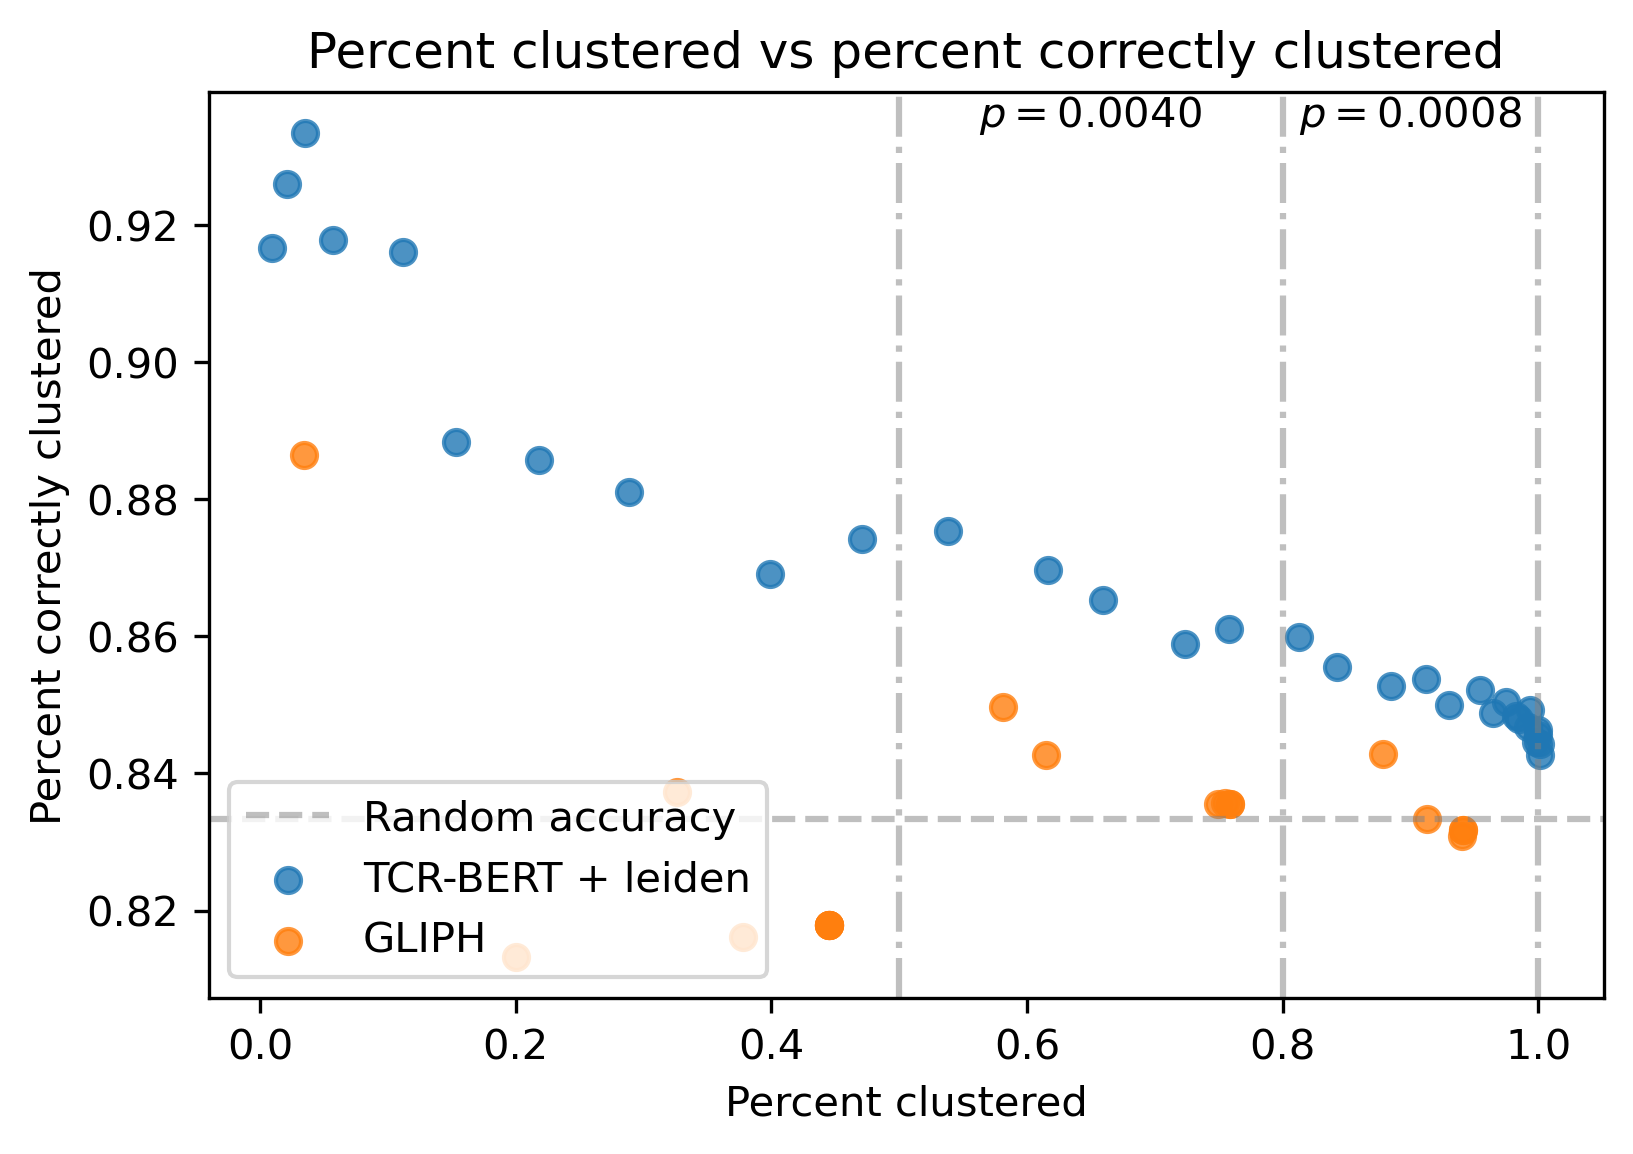

In [37]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    bert_clustering_perf_df['perc_clustered'], bert_clustering_perf_df['perc_correct'],
    alpha=0.8, label="TCR-BERT + leiden",
)
ax.scatter(
    gliph_clustering_perf_df['perc_clustered'], gliph_clustering_perf_df['perc_correct'],
    alpha=0.8, label='GLIPH',
)

# Show the intervals and the p-values
for c in utils.dedup(list(itertools.chain.from_iterable(per_interval_pval.keys()))):
    ax.axvline(c, color='grey', linestyle='-.', alpha=0.5)
_, y_top = ax.get_ylim()
for (begin, end), pval in per_interval_pval.items():
    middle = np.mean([begin, end])
    ax.text(middle, y_top - 0.005, f"$p={pval:.4f}$", ha='center')

ax.set(
    xlabel="Percent clustered",
    ylabel="Percent correctly clustered",
    title="Percent clustered vs percent correctly clustered"
)
ax.axhline(
    1 - np.mean(list(all_labels)),
    color='grey', linestyle='--', alpha=0.5, label='Random accuracy',
)
ax.legend(loc='lower left')

fig.savefig(os.path.join(PLOT_DIR, "glanville_gliph_vs_bert.pdf"), bbox_inches='tight')
fig.show()

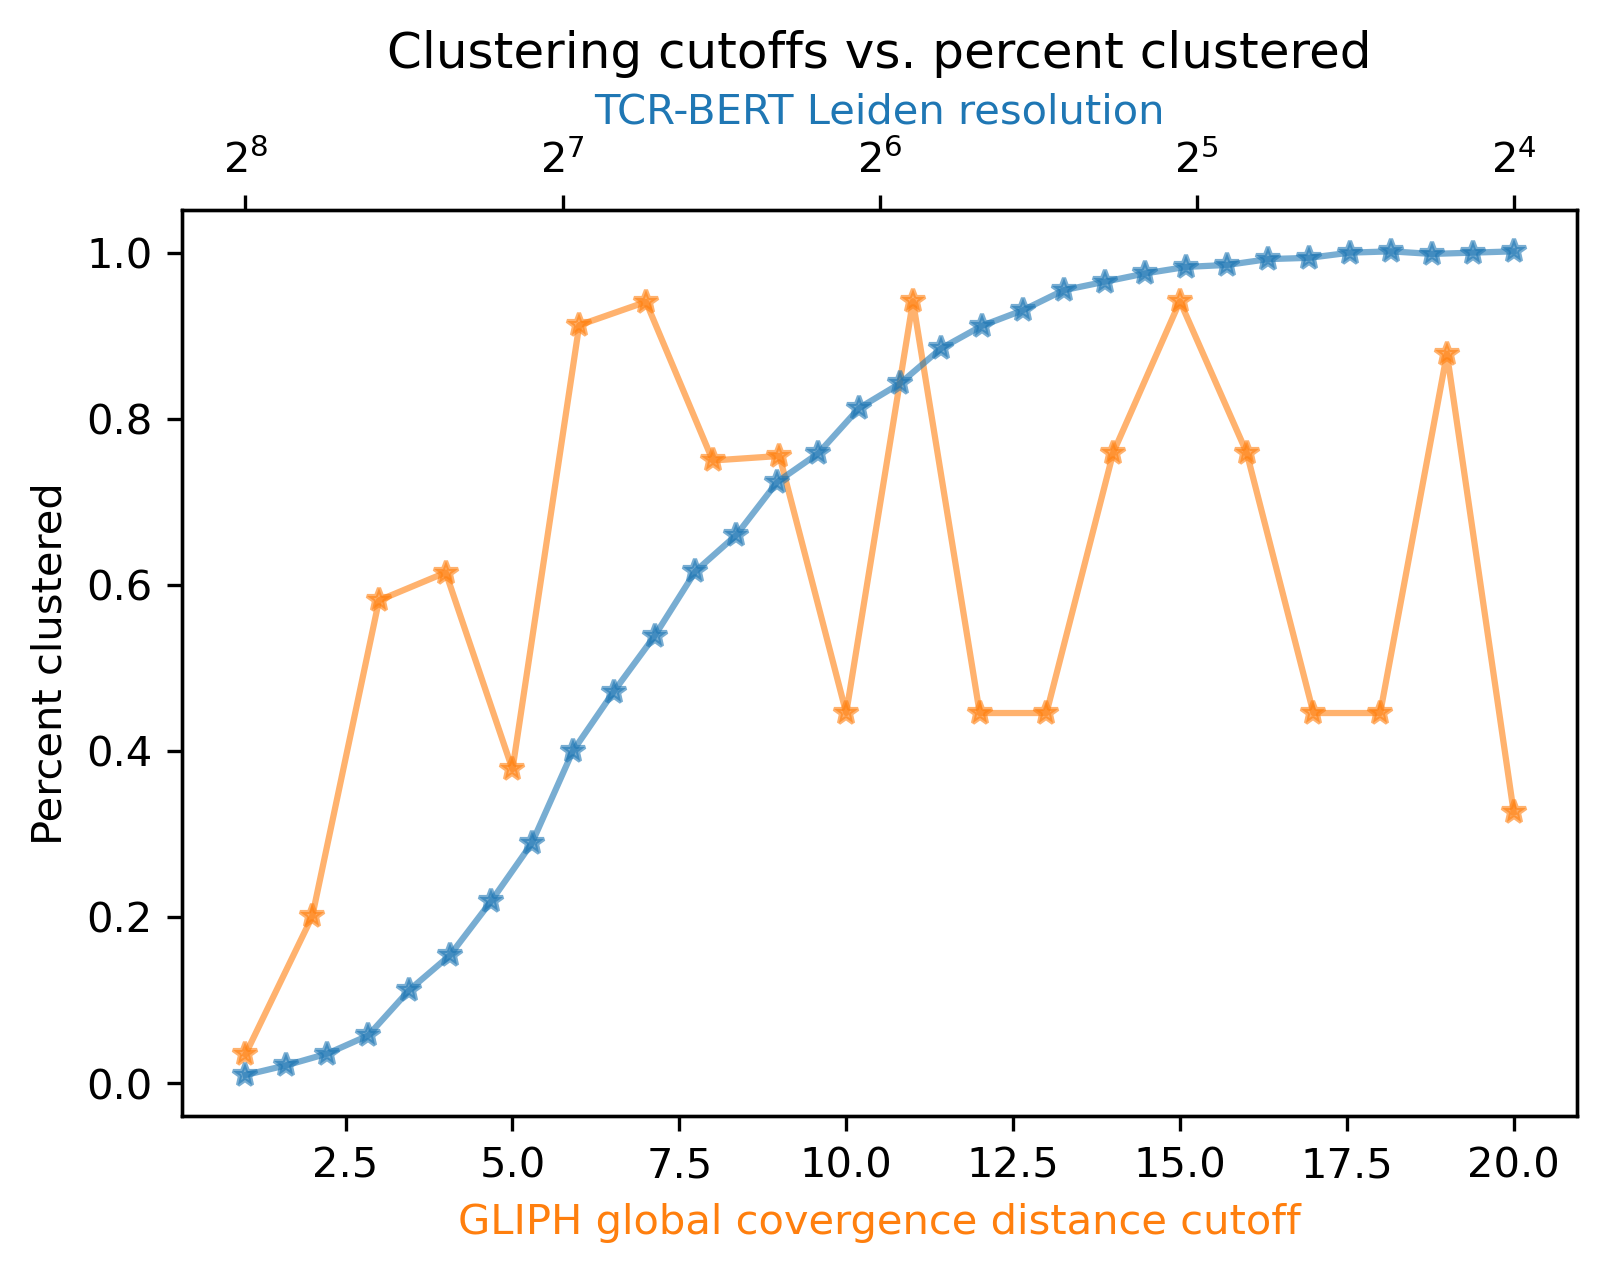

In [38]:
# percentage correct is much more stable for both, not worth plotting really
fig, ax1 = plt.subplots(dpi=300)
color='tab:orange'
ax1.plot(
    gliph_clustering_perf_df.index,
    gliph_clustering_perf_df['perc_clustered'],
    marker="*", color=color, label="GLIPH", alpha=0.6,
)

ax1.set_xlabel("GLIPH global covergence distance cutoff", color=color)
ax1.set(
    ylabel="Percent clustered",
    title="Clustering cutoffs vs. percent clustered",
)

color='tab:blue'
ax2 = ax1.twiny()
ax2.plot(
    bert_clustering_perf_df.index,
    bert_clustering_perf_df['perc_clustered'],
    label='BERT-TCR + leiden', color=color, marker='*', alpha=0.6,
)
ax2.set_xscale('log', base=2)

ax2.set_xlabel("TCR-BERT Leiden resolution", color=color)
ax2.invert_xaxis()

fig.savefig(os.path.join(PLOT_DIR, "glanville_gliph_vs_bert_perc_clustered.pdf"), bbox_inches='tight')
fig.show()

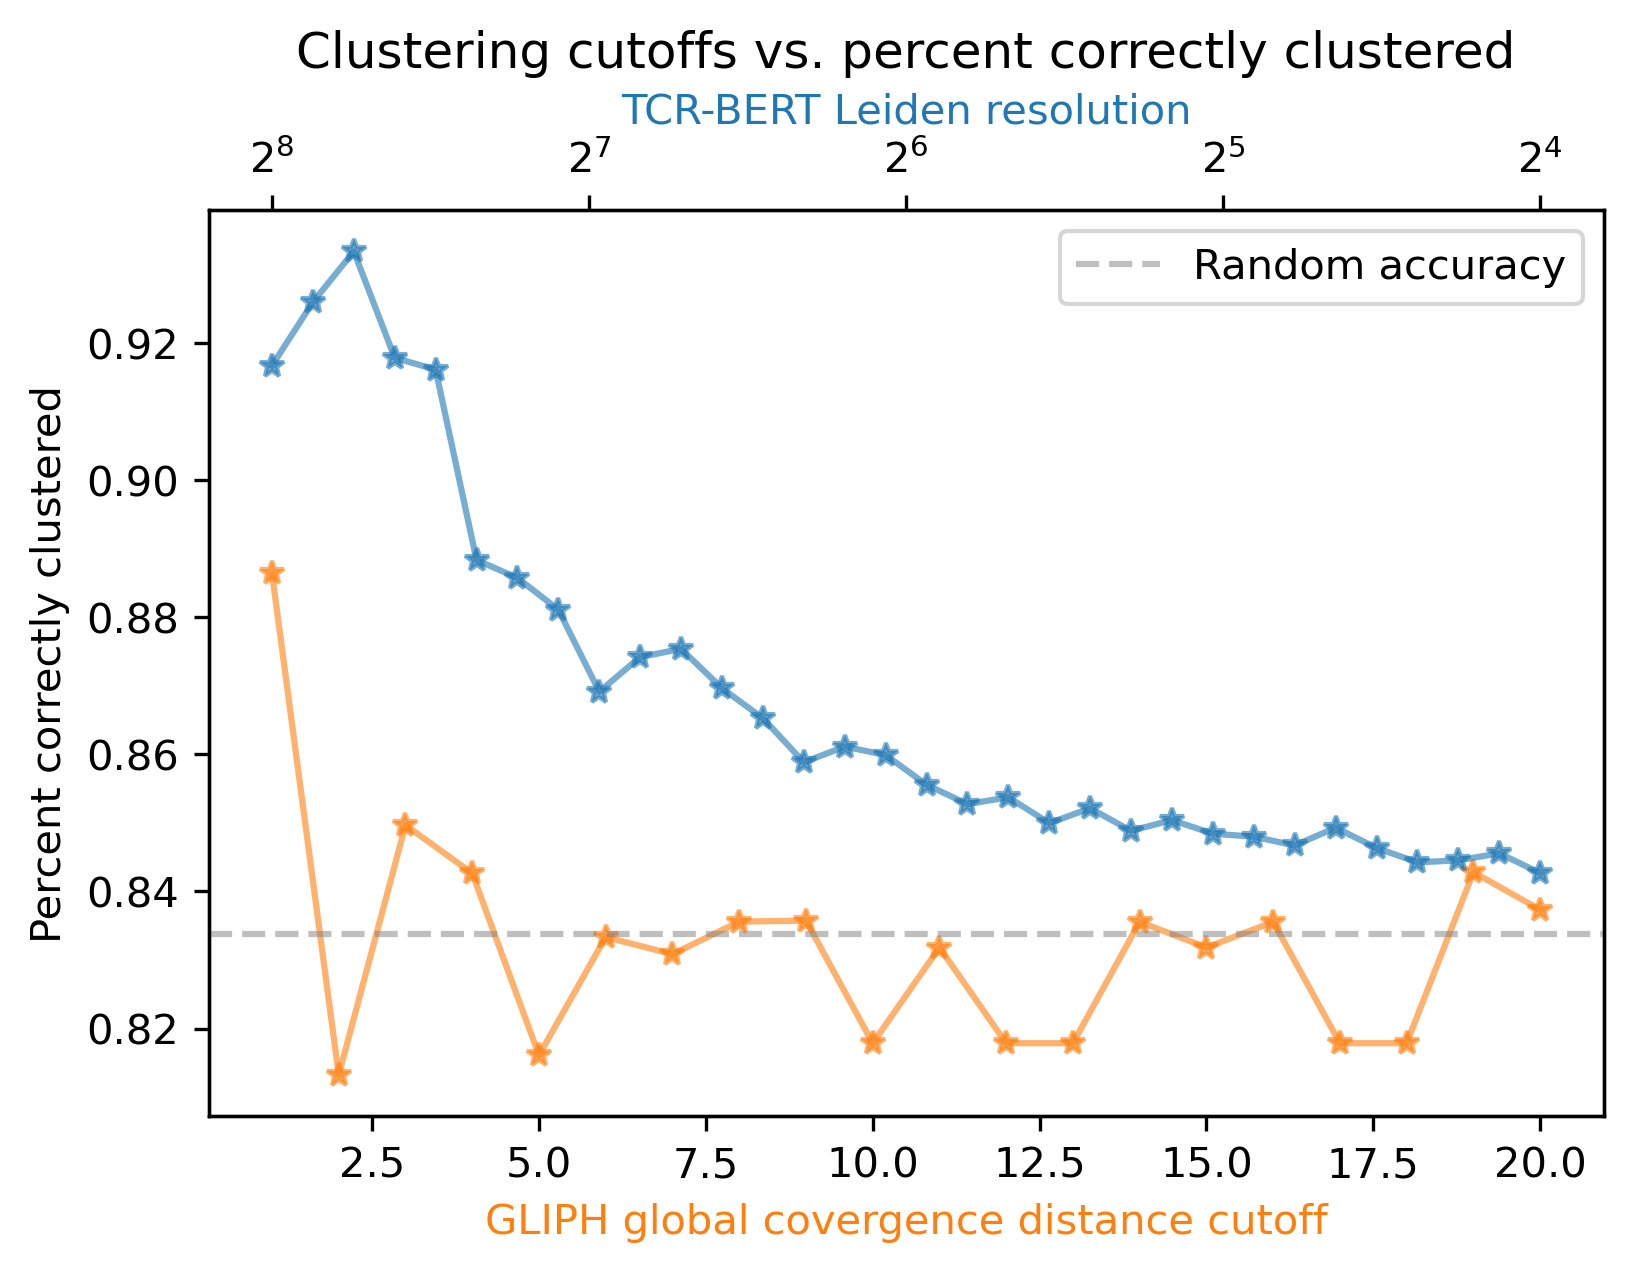

In [39]:
# percentage correct is much more stable for both, not worth plotting really
fig, ax1 = plt.subplots(dpi=300)
color='tab:orange'
ax1.plot(
    gliph_clustering_perf_df.index,
    gliph_clustering_perf_df['perc_correct'],
    marker="*", color=color, label="GLIPH", alpha=0.6,
)

ax1.set_xlabel("GLIPH global covergence distance cutoff", color=color)
ax1.set(
    ylabel="Percent correctly clustered",
    title="Clustering cutoffs vs. percent correctly clustered",
)

color='tab:blue'
ax2 = ax1.twiny()
ax2.plot(
    bert_clustering_perf_df.index,
    bert_clustering_perf_df['perc_correct'],
    color=color, marker='*', alpha=0.6,
)
ax2.set_xscale('log', base=2)

ax2.set_xlabel("TCR-BERT Leiden resolution", color=color)
ax2.invert_xaxis()

ax2.axhline(
    1.0 - np.mean(list(all_labels_dict.values())),
    label="Random accuracy", color='grey', alpha=0.5, linestyle='--'
)
ax2.legend(loc='upper right')

fig.savefig(os.path.join(PLOT_DIR, "glanville_gliph_vs_bert_perc_correct.pdf"), bbox_inches='tight')
fig.show()